---
title: NetOps
subject: Tutorial
subtitle: Notebook for UAV Cal/Val experiment in El Socorro
short_title: UAV Cal/Val experiment
authors:
  - name: Vicente Burchard-Levine
    affiliations:
    - Instituto de Ciencias Agrarias, ICA
    - CSIC
    orcid: 0000-0003-0222-8706
    email: vburchard@ica.csic.es
  - name: Juan José Peón
    affiliations:
    - Área de Sistemas de Teledetección
    - INTA
    orcid: 000
    email: jpeogar@inta.es
  - name: Héctor Nieto
    affiliations:
      - Instituto de Ciencias Agrarias, ICA
      - CSIC
    orcid: 0000-0003-4250-6424
    email: hector.nieto@ica.csic.es
  - name: Your names
    affiliations:
    - Your affiliation
    - Acronymn
    orcid: your orcid
---

# Summary
This notebook will perform a step-by-step guide on how to perform a calibration and valitation (Cal/Val) of different UAV-based sensors using vicarious in-situ measurements during UAV overpasses. 

The data were collected on September 19th, 2022 in the El Socorro experimental vineyard farm managed by IMIDRA during PTI TELEDETECT workshop

## Table of Contents 
0. [Create python environment and import libraries](#Install-libraries-and-dependencies)
1. [Image selection](#Select-and-image-to-work-with)
2. [Visualize and preprocess insitu ASD data](#Preprocess-ASD-data)
3. [Extracting UAV data over reference panels](#Extract-UAV-values-over-reference-panels)
4. [Develop empirical line](#Develop-empirical-line)
5. [Calibrate and validate imagery based on empirical line](#Calibrate-image-with-developed-empirical-model)

:::{important} Instuctions
No programming skills are required to follow up this notebook.

Once each section is read, run the jupyter code cell underneath (marked as `[]`) by clicking the icon `Run`, or pressing the keys SHIFT+ENTER of your keyboard.
::::{hint}
However, if you feel confortable with Python, you are very welcome to edit the code and provide suggestions in this collaborative framework.
::::
:::

----

Code adapted from a [AET 2024](http://eo.csic.es/aet2024) course led by Juan José Peón | Área de Sistemas de Teledetección | Instituto Nacional de Técnica Aeroespacial (INTA) | jpeogar@inta.es

Original code available here: https://colab.research.google.com/drive/14GBdZ9rsC3nep4FKEVtSN-1VdcnB6kca?usp=sharing 

----

# Install libraries and dependencies

First step is to make sure you have all the dependencies. Refer to the readme file to install all dependencies. It also recommended to create a conda environment or make sure all libraries necessary are correctly installed.

## Installation

You should have these programs installed:

* Python and/or [Anaconda](https://www.anaconda.com/download/success). 

Install the requirements either with conda/mamba:

`mamba env create -f environment.yml`

or

`conda env create -f environment.yml`

or 

Make sure you have the required libraries installed:
- jupyter
- notebook
- jupyterlab
- jupyter-book
- gdal
- numpy
- scipy
- pandas
- matplotlib
- geopandas
- pathlib
- scikit-learn
- mystmd
- jupyterlab-myst


## Run the interactive book
Run the following command to initialize the book:

1. Activate python environment 

`conda activate calval-netops`

2. Initialize jupyter notebook
  
`jupyter notebook uav_calval_socorro.ipynb`

or 

`jupyter lab uav_calval_socorro.ipynb`



# Import Libraries	

In [1]:
import json
import zipfile
import getpass
import numpy as np 
import pandas as pd 
import geopandas as gpd 
from osgeo import gdal 
from pathlib import Path 
import matplotlib.pyplot as plt 
from scipy.stats import linregress
from ipywidgets import interact, interactive, fixed, widgets
from IPython.display import display, Markdown, Latex
import owncloud

print('libraries imported correctly!')

libraries imported correctly!


# Get the data from the NetOps SACO drive
First we need to provide our credentials to access CSIC's SACO:

In [ ]:
user_name = input('Type your SACO user name: ')
password = getpass.getpass("Type your SACO password: ")

Now we can download the workshop dataset in the `dataset2` folder

In [ ]:
overwrite = False

SACO_URL = 'https://saco.csic.es'
netops_dir = "NetOPS/data/calval-UAV/"
print("Connecting to {SACO_URL}")
oc = owncloud.Client(SACO_URL)
dst_path = Path("./dataset/")
# We only download the data once, unless overwrite==True
if not dst_path.is_dir() and not overwrite:
    temp_zip = f"{dst_path.name}.zip"
    oc.login(user_name, password)
    print(f"Downloading dataset to {temp_zip}... this could take a while")
    oc.get_directory_as_zip(netops_dir, temp_zip)
    print(f"Extracting zip to {dst_path}")
    with zipfile.ZipFile(temp_zip, 'r') as zip_ref:
        zip_ref.extractall(dst_path)
else:
    print("Dataset already downloaded, you can skip this cell")
    
print("Logging out from SACO")
oc.logout()

## Dataset summary
A total of **10 UAV overpasses** were performed on September 19th, 2022, which included **6 multispectral** sensors, **3 thermal infrared** sensors, and **1 hyperspectral** sensor. 

See table below for a summary:
:::{table} Image characteristics
:name: images-description
|Sensor|Sensor Type |Group |Flight Time (UTC)   
| :---     | :--- | :---  | :---   
| P4M      |multi | ICMAN  | 08:43
| P4M      |multi | ICMAN  | 09:14
| Sequoia+ |multi | ICA  | 09:42
| Micasense|multi | ICMAN  | 10:24
| Micasense|multi | ICMAN  | 10:51
| P4M|multi | GEOINCA  | 11:29
| H20T|TIR| ICA  | 09:42
| M2EA|TIR| ICMAN  | 11:30
| M2EA|TIR| ICMAN  | 11:40
| Cubert S185|Hyper| EBD  | 11:57
:::

This notebook will use the **Sequoia+ orthomosaic** as an example to perform the cal/val using the empirical line approach based on in-situ ASD measurements over reference panels. 

# Select and image to work with

First we will select from {ref}`images-description` the images we will work with:

In [2]:
# set work directory (change if the 'dataset' folder is in a different path than the notebook)
workdir = Path()

uav_base_dir = workdir / 'dataset' / 'uav_imagery' / 'multi' 

# shapefile directory 
vector_dir = workdir / 'dataset' / 'vector_data'

# panel outline shapefile 
panels_file = vector_dir/'panels_borders.geojson'

# open as geopandas dataframe
panels_gdf = gpd.read_file(panels_file)

w_image = widgets.Dropdown(
    options=[('P4M at 08:43', "P4M_ICMAN_0843"), ('P4M at 09:14', "P4M_ICMAN_0914"), 
             ('Sequoia+ at 09:42', "Sequoia_ICA_0942"),
             ('Micasense at 10:24', "Micasense_ICMAN_1024"), ('Micasense at 1051', "Micasense_ICMAN_1051"),
             ('P4M at 11:29', "P4M_GEOINCA_1129"), ('Cubert at 11:57', "Cubert_EBD_1157")
            ],
    value="Sequoia_ICA_0942",
    description='Image:',
)

display(Markdown("## Select an image"), w_image)

## Select an image

Dropdown(description='Image:', index=2, options=(('P4M at 08:43', 'P4M_ICMAN_0843'), ('P4M at 09:14', 'P4M_ICM…

## Visualize UAV image

**Reading information from Sequoia sensor owned by ICA and acquired at 09:42**

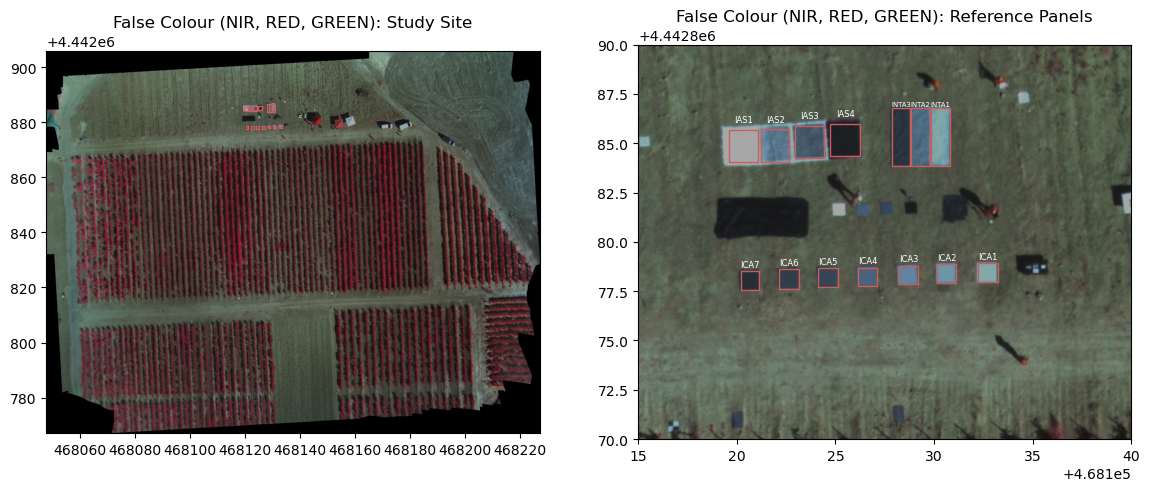

In [3]:
# We get the image information from the widget selection
sensor_name, sensor_group, sensor_time = w_image.value.split("_")
display((Markdown(f"**Reading information from {sensor_name} sensor owned by {sensor_group} and acquired at {sensor_time[:2]}:{sensor_time[2:]}**")))

uav_dir = uav_base_dir / f"{sensor_name}_{sensor_group}" / 'mosaic'

# get orthomosaic file
mosaic_file = uav_dir / f'Mosaic_REF_{w_image.value}.tif'

# open as GDAL object
fid = gdal.Open(str(mosaic_file))

# get geotransform and other metadata
geotransform = fid.GetGeoTransform()
minx, maxy = geotransform[0], geotransform[3]
maxx = minx + geotransform[1] * fid.RasterXSize
miny = maxy + geotransform[5] * fid.RasterYSize

# Read specific bands (4=NIR, 3=Red-Edge,2=Red and 1=Green)
nir_band = fid.GetRasterBand(4).ReadAsArray()  # Near-Infrared
rededge_band = fid.GetRasterBand(3).ReadAsArray()  # Red-edge
red_band = fid.GetRasterBand(2).ReadAsArray()  # Red
green_band = fid.GetRasterBand(1).ReadAsArray()  # Green

# Stack the bands to obtain false colour image: R=NIR, G=Red, B=Green
false_color_image = np.dstack((nir_band, red_band, green_band))

# make side by side false colour figure
fig, axes = plt.subplots(1,2, figsize=(14,14))

# whole study area
ax1 = axes[0]
ax1.imshow(false_color_image, extent=[minx, maxx, miny, maxy])
# overlay reference panel borders
panels_gdf.plot(ax=ax1, facecolor='none', edgecolor='indianred', linewidth=1)

ax1.set_title('False Colour (NIR, RED, GREEN): Study Site')

# zoom to reference panels
ax2 = axes[1]
ax2.imshow(false_color_image, extent=[minx, maxx, miny, maxy])
# overlay reference panel borders
panels_gdf.plot(ax=ax2, facecolor='none', edgecolor='indianred', linewidth=1)
# 4. Annotate the plot with labels from the GeoDataFrame
for idx, row in panels_gdf.iterrows():
    # Get the centroid of the geometry (or use point coordinates directly)
    if row.geometry.geom_type == 'Point':
        x, y = row.geometry.x, row.geometry.y  # For points
    else:
        x, y = row.geometry.centroid.x, row.geometry.centroid.y  # For polygons
        
    if row['code'][:-1] == 'INTA':
        # Annotate the map with the 'name' field (or any other attribute)
        ax2.annotate(text=row['code'], xy=(x, y),  xytext=(x, y+1.6), xycoords='data',
                    fontsize=5, ha='center', color='white')
    elif row['code'][:-1] == 'IAS':
        # Annotate the map with the 'name' field (or any other attribute)
        ax2.annotate(text=row['code'], xy=(x, y),  xytext=(x, y+1.2), xycoords='data',
                    fontsize=6, ha='center', color='white')
    else:
        # Annotate the map with the 'name' field (or any other attribute)
        ax2.annotate(text=row['code'], xy=(x, y),  xytext=(x, y+0.7), xycoords='data',
                    fontsize=6, ha='center', color='white')
        
ax2.set_title('False Colour (NIR, RED, GREEN): Reference Panels')
# set xy lim to zoom to panels, change for different zoom extent
ax2.set_xlim(468115,468140)
ax2.set_ylim(4442870,4442890)
plt.show()

# Preprocess ASD data

ASD measurements were acquired over the references panels visible in the right panel of the above figure. 

Three different rounds of measurements were acquired (R1, R2 and R3)

In [5]:
# get asd file directory
asd_file = workdir / 'dataset' / 'insitu' / 'ASDFieldSpec3_16120_SpecLab' / 'socorro_asd_panels_mean_all_IAScor.csv' 

# open asd file as a pandas directory
asd_df = pd.read_csv(asd_file)

# show first five rows
#print(asd_df.head())

# get wavelengths as series
wl_asd = asd_df["Wavelength"].values

# get id of all panels (omiting the first column which is the wavelength)
id_panel = asd_df.columns[1:]

# get panel ID to identify the panel type (i.e. INTA1, INTA2, INTA3 etc) i.e. remove round number 'R1', 'R2' etc
id_panel_type = id_panel.str.split('_').map(lambda x: x[0])
# get unique values of ID
panels_unique = id_panel_type.unique()

print(f'Panel IDs:\n{list(id_panel)}\n')
print(f'Panel groups:\n{list(panels_unique)}\n')


Panel IDs:
['ICA1_R1', 'ICA1_R2', 'ICA1_R3', 'ICA2_R1', 'ICA2_R2', 'ICA2_R3', 'ICA3_R1', 'ICA3_R2', 'ICA3_R3', 'ICA4_R1', 'ICA4_R2', 'ICA4_R3', 'ICA5_R1', 'ICA5_R2', 'ICA5_R3', 'ICA6_R1', 'ICA6_R2', 'ICA6_R3', 'ICA7_R1', 'ICA7_R2', 'ICA7_R3', 'INTA1_R1', 'INTA1_R2', 'INTA1_R3', 'INTA2_R1', 'INTA2_R2', 'INTA2_R3', 'INTA3_R1', 'INTA3_R2', 'INTA3_R3', 'IAS4_R1', 'IAS4_R2', 'IAS4_R3', 'IAS3_R1', 'IAS3_R2', 'IAS3_R3', 'IAS2_R1', 'IAS2_R2', 'IAS2_R3', 'IAS1_R1', 'IAS1_R2', 'IAS1_R3']

Panel groups:
['ICA1', 'ICA2', 'ICA3', 'ICA4', 'ICA5', 'ICA6', 'ICA7', 'INTA1', 'INTA2', 'INTA3', 'IAS4', 'IAS3', 'IAS2', 'IAS1']



## Visualize ASD data

In [25]:
group = 'IAS'
groups_select = list(panels_unique[panels_unique.str.contains(group)])
groups_select.sort()
groups_select

['IAS1', 'IAS2', 'IAS3', 'IAS4']

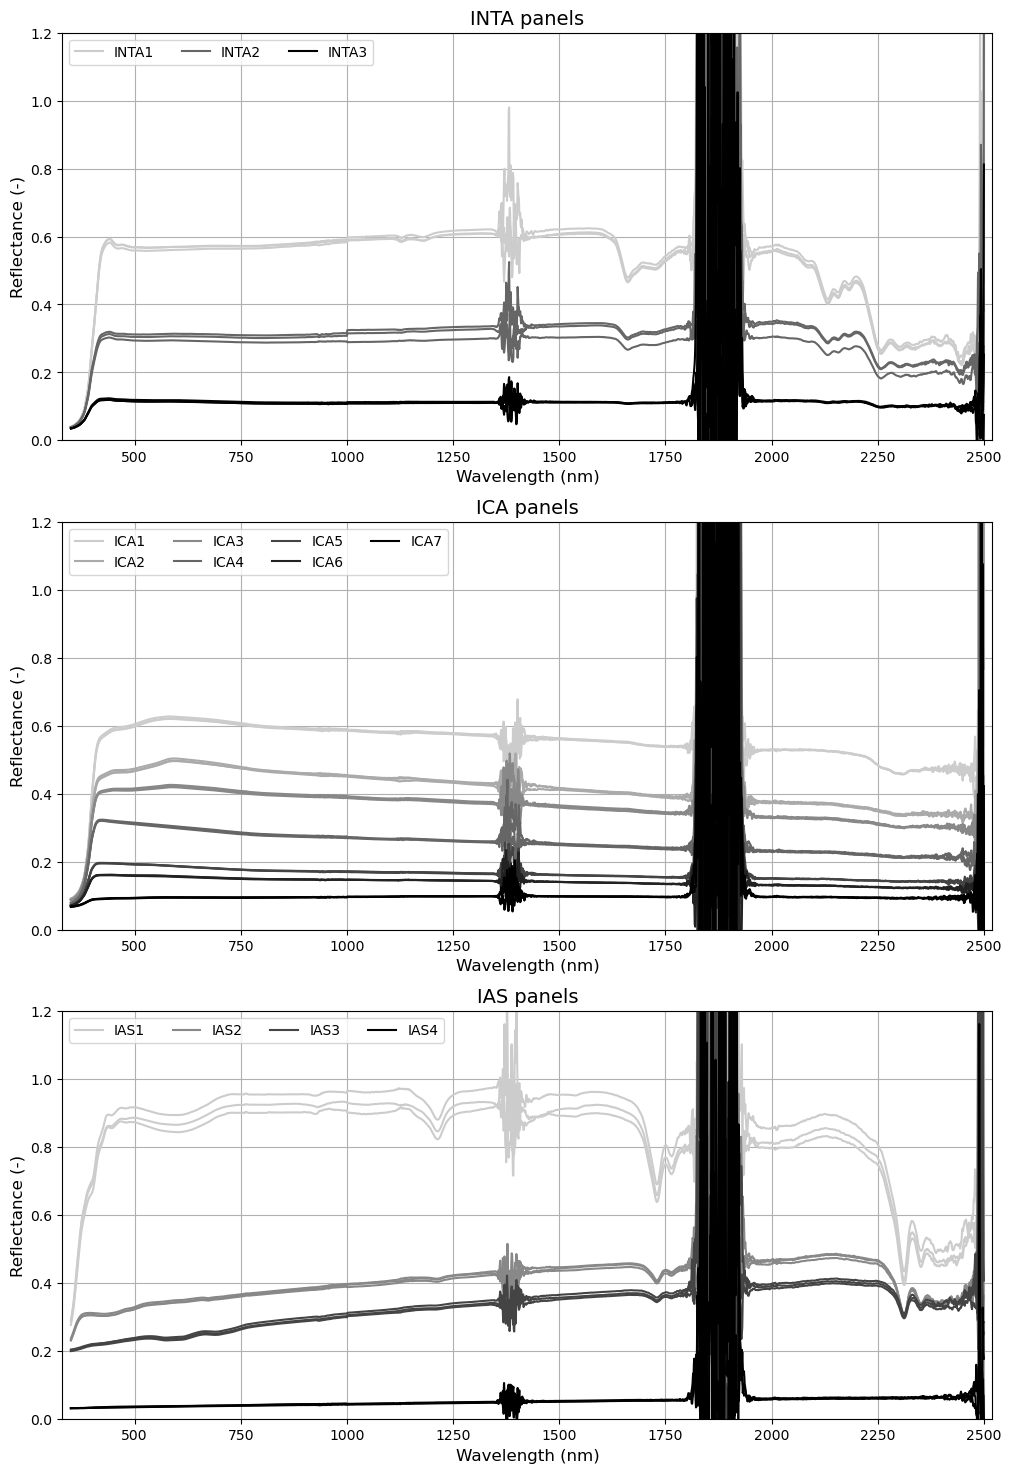

In [26]:
# list of the panels from different groups
panel_groups = ['INTA', 'ICA', 'IAS']

# create 3x1 plot with each panel group 
fig, axes = plt.subplots(3,1, figsize=(12,18))
i = 0
for group in panel_groups:
    # select all panels related to this group (INTA, ICA or IAS)
    groups_select = list(panels_unique[panels_unique.str.contains(group)])
    # sort from panel 1 to 4
    groups_select.sort()
    
    # intialize axis
    ax = axes[i]
    ax.set_title(f'{group} panels', fontsize=14)
    ax.set_xlabel('Wavelength (nm)', fontsize=12)
    ax.set_xlim(330, 2520)
    ax.set_ylabel('Reflectance (-)', fontsize=12)
    ax.set_ylim(0, 1.2)
    ax.grid(True)
    
    # create light to dark gradient depending on number of panels
    color_gradient = np.linspace(0.8, 0, len(groups_select)).astype(str)
    # plot for each panel number
    for n, g in enumerate(groups_select):
      cols = id_panel[id_panel.str.contains(g)]
      panel_number = asd_df[cols]
      # plot each of the spectra (each round)
      for col in panel_number.columns:
        ax.plot(wl_asd, panel_number[col].values, label=g, color=color_gradient[n])
    i = i + 1
    
# create legend for each subplot
for ax in axes:
    handles, labels = ax.get_legend_handles_labels()
    
    # Create a dictionary to remove duplicates (preserves the first occurrence)
    unique = dict(zip(labels, handles))
    
    # Add the legend with only the unique panel labels and color
    ax.legend(unique.values(), unique.keys(), loc='upper left', ncols = len(groups_select))

plt.show()

## Convolve ASD spectra using the spectral response function (SRF)

First we need to convolve the ASD measurements (400-2500nm) to the spectral response function of the sensor

**Sequoia_ICA**

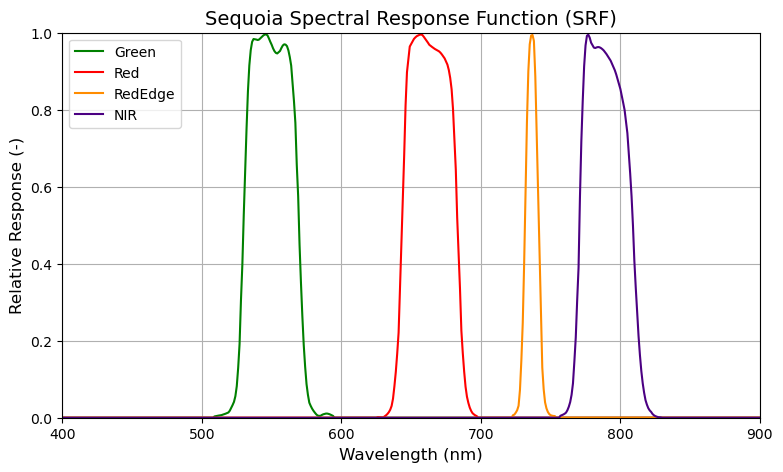

In [27]:
# spectral response function (SRF) file 
display(Markdown(f"**{sensor_name}_{sensor_group}**"))
srf_file = workdir / 'dataset' / 'uav_imagery' / 'multi' / f"{sensor_name}_{sensor_group}" / f'SRF_{sensor_name}.txt'

# open as pandas dataframe
srf_df = pd.read_csv(srf_file, sep = '\t')

band_names = srf_df.columns[1:]

# Show spectral response function (SRF) curves
plt.figure(figsize=(9, 5))
plt.title('Sequoia Spectral Response Function (SRF)', fontsize=14)
plt.xlabel('Wavelength (nm)', fontsize=12)
plt.xlim(400, 900)
plt.ylabel('Relative Response (-)', fontsize=12)
plt.ylim(0, 1)
plt.grid(True)
colors = ['g', 'r', 'darkorange', 'indigo']
i = 0
for band in band_names:
    plt.plot(srf_df['Wavelength_nm'], srf_df[band], color=colors[i], label = str(band))
    i += 1
plt.legend(loc='upper left')
plt.show()

In [55]:
# initialize empty dictionary to store results
asd_convolved_dict = {'panels': []} 

# go through all panels (ICA1, ICA2 etc)
for panel in id_panel:
    asd_data = asd_df[panel]
    # add panel id to output dictonary
    asd_convolved_dict['panels'].append(panel)
    # for each band, apply SRF on ASD spectra
    for band in band_names:
        asd_band = np.sum(asd_data * srf_df[band])/np.sum(srf_df[band])
        # store result in output dictionary
        if band in asd_convolved_dict:
            asd_convolved_dict[band].append(asd_band)
        else:
            asd_convolved_dict[band] = []
            asd_convolved_dict[band].append(asd_band)
            
# convert output dictionary into pandas dataframe
asd_convolved_df = pd.DataFrame(asd_convolved_dict)
asd_convolved_df.head()

panels     Green       Red   RedEdge       NIR
0  ICA1_R1  0.622660  0.620563  0.609648  0.601138
1  ICA1_R2  0.616955  0.615460  0.604666  0.596809
2  ICA1_R3  0.615403  0.614061  0.604646  0.597831
3  ICA2_R1  0.489859  0.495015  0.481341  0.471423
4  ICA2_R2  0.483916  0.489366  0.476379  0.467363

## Plot convolved ASD data over reference panels

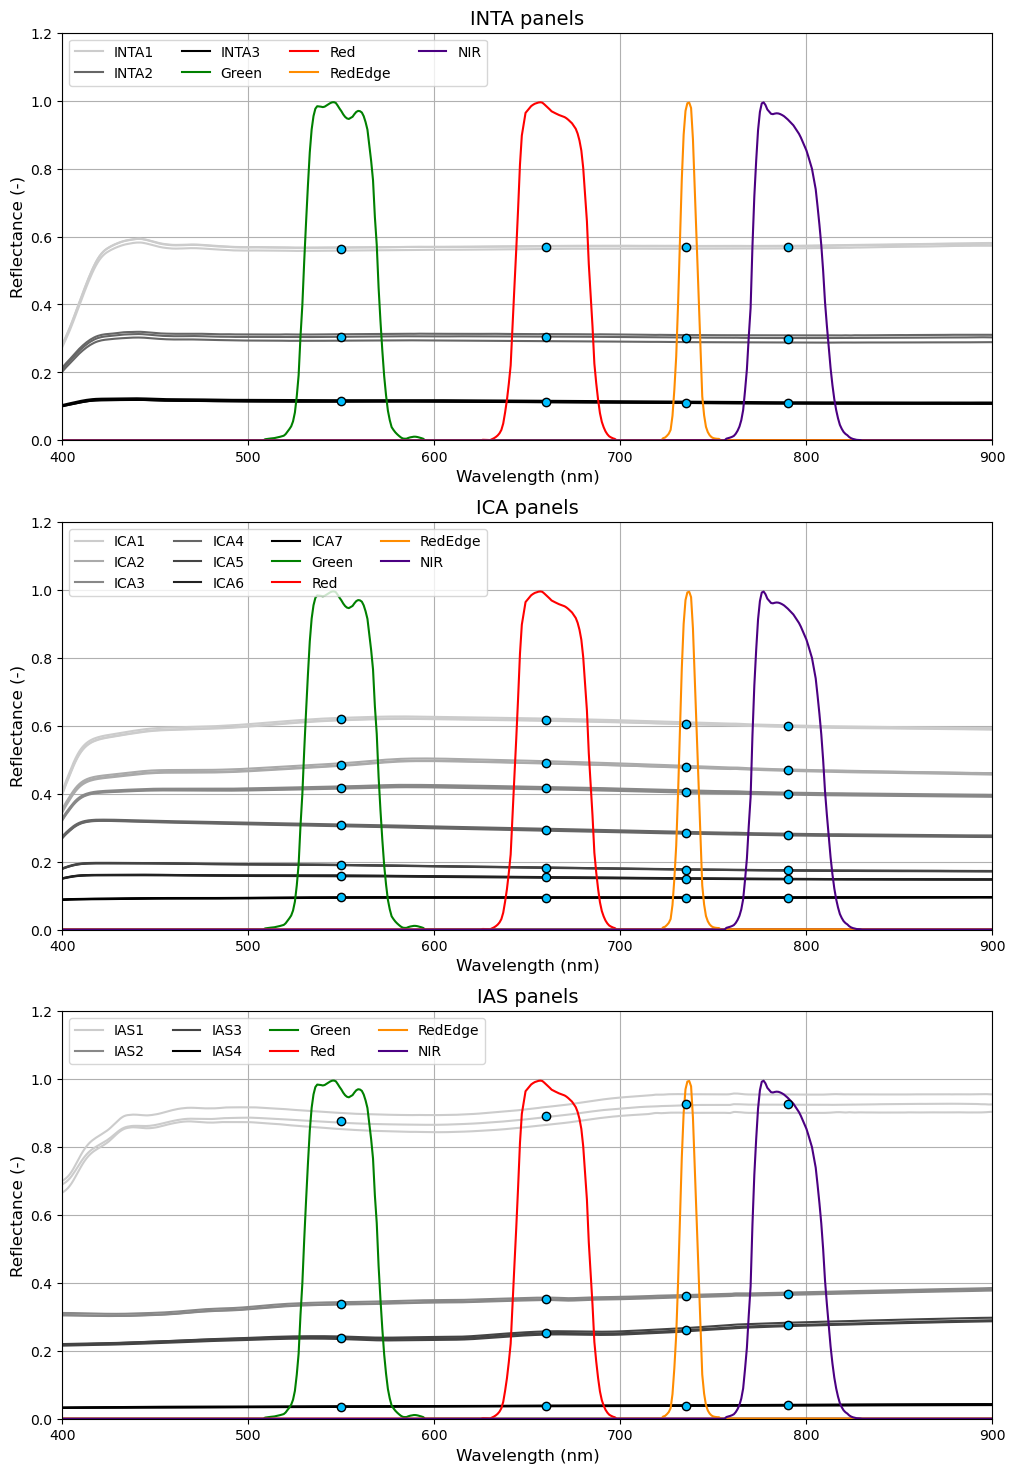

In [33]:
# sensor center wl for each band
sensor_band_center_dict = {"Sequoia": [550, 660, 735, 790],
                           "Micasense": [550, 660, 735, 790],
                           "PM4":[550, 660, 735, 790]}


sensor_band_center = sensor_band_center_dict[sensor_name]

# create 3x1 plot with each panel group 
fig, axes = plt.subplots(3,1, figsize=(12,18))
i = 0
for group in panel_groups:
    
    # select all panels related to this group (INTA, ICA or IAS)
    groups_select = list(panels_unique[panels_unique.str.contains(group)])
    # sort from highest reflectance to lowest
    groups_select.sort()
    # intialize axis
    ax = axes[i]
    ax.set_title(f'{group} panels', fontsize=14)
    ax.set_xlabel('Wavelength (nm)', fontsize=12)
    ax.set_xlim(400, 900)
    ax.set_ylabel('Reflectance (-)', fontsize=12)
    ax.set_ylim(0, 1.2)
    ax.grid(True)
    
    # create light to dark gradient depending on number of panels
    color_gradient = np.linspace(0.8, 0, len(groups_select)).astype(str)
    
    # plot for each panel number
    for n, g in enumerate(groups_select):
      cols = id_panel[id_panel.str.contains(g)]
      panel_number = asd_df[cols]
        
      # plot each of the spectra (each round)
      for col in panel_number.columns:
        ax.plot(wl_asd, panel_number[col].values, label=g, color=color_gradient[n])

    # plot spectral response function
    colors = ['g', 'r', 'darkorange', 'indigo']
    n = 0
    for band in band_names:
        ax.plot(srf_df['Wavelength_nm'], srf_df[band], color=colors[n], label = str(band))
        n = n + 1
    # get mean ASD values convolved to Sequoia bands
    for g in groups_select:
        srf_mask = asd_convolved_df['panels'].str.contains(g)
        convolved_values = asd_convolved_df[srf_mask]
        j = 0
        for band in band_names:
            asd_band_values = np.mean(convolved_values[band])
            ax.plot(sensor_band_center[j], asd_band_values, 'o', ms=6, c='black', mfc='deepskyblue')
            j = j +1
    
    i = i + 1
    
# create legend for each subplot
for ax in axes:
    handles, labels = ax.get_legend_handles_labels()
    
    # Create a dictionary to remove duplicates (preserves the first occurrence)
    unique = dict(zip(labels, handles))
    
    # Add the legend with only the unique panel labels and color
    ax.legend(unique.values(), unique.keys(), loc='upper left', ncols = len(groups_select))

plt.show()

# Extract UAV values over reference panels
Here, we will use the centroid of each panel shapefile and extract values over a radius of 25x25cm

:::{note}
Different approaches can be applied to extract UAV data over panels. This is just an example, we can discuss if we should test other approaches
:::



## Select which method you would use to extract the ASD information from the panels

In [34]:
methods = [('Centroid point', 'centroid'),
           ('30cm buffer to centroid', 'centroid_buffer30cm'),
           ('Borders polygon', "borders")
         ]

w_extraction =widgets.Dropdown(
    options=methods,
    value="centroid",
    description='Extraction method:',
)

display(w_extraction)

Dropdown(description='Extraction method:', options=(('Centroid point', 'centroid'), ('30cm buffer to centroid'…

### Visualize the geometry

In [35]:
# shapefile directory 
vector_dir = workdir / 'dataset' / 'vector_data'

print(f"Reading the geometry from {w_extraction.label}")
# panel outline shaefile 
panels_file = vector_dir / f'panels_{w_extraction.value}.geojson'

# open panel point shapefile as geopandas dataframe
panels_gdf = gpd.read_file(panels_file)
display(Markdown(f':::{{table}} Calibration pannel geometry\n{panels_gdf.to_markdown(index=False, floatfmt=".4f")}\n:::'))

Reading the geometry from Centroid point


:::{table} Calibration pannel geometry
|   ID | code   | geometry                                     |
|-----:|:-------|:---------------------------------------------|
|    1 | ICA1   | POINT (468132.71973375 4442878.4271273)      |
|    2 | ICA2   | POINT (468130.6230033 4442878.3789266)       |
|    3 | ICA3   | POINT (468128.69497529994 4442878.306625549) |
|    4 | ICA4   | POINT (468126.6223452 4442878.21022415)      |
|    5 | ICA5   | POINT (468124.6220161499 4442878.1861237995) |
|    6 | ICA6   | POINT (468122.64578745 4442878.113822749)    |
|    7 | ICA7   | POINT (468120.66955875006 4442878.0415217)   |
|    8 | INTA1  | POINT (468130.3337991001 4442885.295727051)  |
|    9 | INTA2  | POINT (468129.32158439996 4442885.29572705)  |
|   10 | INTA3  | POINT (468128.33347004995 4442885.29572705)  |
|   11 | IAS4   | POINT (468125.4896287501 4442885.1752253)    |
|   12 | IAS3   | POINT (468123.68210249994 4442885.05472355)  |
|   13 | IAS2   | POINT (468121.9468773001 4442884.8860211)    |
|   14 | IAS1   | POINT (468120.33215384994 4442884.86192075)  |
:::

In [36]:
from rasterstats import zonal_stats
no_data_value = 0
# Choose which zonal statistics you want to extract: "count min mean max median"
stat = "mean"
uav_values_df = pd.DataFrame(columns=["panel_id"])

with gdal.Open(mosaic_file) as fid:
    num_bands = fid.RasterCount

for b in range(num_bands):
    # Define the name of the band
    col_id = f'B{b+1}_val'
    # Extract zonal statistics using Raster Stats
    extract_json = zonal_stats(panels_gdf, mosaic_file, band_num=b, stats=stat, geojson_out=True, nodata=no_data_value)
    # Loop along the panels extracted and create a table
    panel_values = {"panel_id": [], col_id:[]}
    for p in extract_json:
        panel_name = p["properties"]["code"]
        panel_values["panel_id"].append(panel_name)
        panel_values[col_id].append(p["properties"][stat])
        
    panel_values = pd.DataFrame(panel_values)
    # Join tables
    uav_values_df = pd.merge(uav_values_df, panel_values, on="panel_id", how="outer")

# Saving extractions to a CSV file
csv_output = uav_dir / f'Mosaic_REF_{w_image.value}_{w_extraction.value}.csv'
uav_values_df.to_csv(csv_output, index=False, sep=";")
print(f"Extractions saved in {csv_output}")

# Display table
display(Markdown(f':::{{table}} Calibration pannel extractions using {w_extraction.value}s\n{uav_values_df.to_markdown(index=False, floatfmt=".4f")}\n:::'))

Extractions saved in dataset/uav_imagery/multi/Sequoia_ICA/mosaic/Mosaic_REF_Sequoia_ICA_0942_centroid.csv


:::{table} Calibration pannel extractions using centroids
| panel_id   |   B1_val |   B2_val |   B3_val |   B4_val |
|:-----------|---------:|---------:|---------:|---------:|
| IAS1       |   0.6554 |   0.6554 |   0.6554 |   0.6554 |
| IAS2       |   0.5607 |   0.5607 |   0.4534 |   0.4126 |
| IAS3       |   0.3762 |   0.3762 |   0.3188 |   0.2933 |
| IAS4       |   0.1319 |   0.1319 |   0.1213 |   0.1192 |
| ICA1       |   0.6554 |   0.6554 |   0.6554 |   0.6553 |
| ICA2       |   0.6554 |   0.6554 |   0.5911 |   0.5263 |
| ICA3       |   0.6278 |   0.6278 |   0.5154 |   0.4672 |
| ICA4       |   0.4863 |   0.4863 |   0.3848 |   0.3498 |
| ICA5       |   0.3297 |   0.3297 |   0.2759 |   0.2578 |
| ICA6       |   0.2833 |   0.2833 |   0.2351 |   0.2304 |
| ICA7       |   0.2028 |   0.2028 |   0.1762 |   0.1685 |
| INTA1      |   0.6554 |   0.6554 |   0.6554 |   0.6553 |
| INTA2      |   0.4943 |   0.4943 |   0.3990 |   0.3462 |
| INTA3      |   0.2372 |   0.2372 |   0.2004 |   0.1845 |
:::

# Develop empirical line
## Plot UAV vs ASD reflectance over reference panel

:::{important}
For now only testing with ASD measurements from Round 1 (R1).
:::


## Calibrating image reflectance 

We will calibrate the UAV images using the empirical line approach using the reference panels.

:::{math}
\rho_{cal} = \mathbf{gain} (\rho_{original}) + \mathbf{offset}
:::

When we have three or more references (e.g. panels), then we perform the calibration by fitting a linear regression model
### Fit linear models

In [57]:
groups_select = list(panels_unique[panels_unique.str.contains(group)])
groups_select.sort()
groups_select
asd_data = asd_convolved_df[asd_convolved_df['panels'].str.contains(group) & asd_convolved_df['panels'].str.contains('R1')]
asd_data
uav_data = uav_values_df[uav_values_df['panel_id'].str.contains(group)] 
asd_data
band = 'NIR'
asd_values = asd_data[band].values 
uav_values = uav_data[f'B{4}_val'].values
asd_data.sort_values(by = ['panels'])

panels     Green       Red   RedEdge       NIR
39  IAS1_R1  0.900551  0.919820  0.955219  0.954321
36  IAS2_R1  0.335967  0.348635  0.357570  0.364630
33  IAS3_R1  0.241549  0.256196  0.267335  0.282360
30  IAS4_R1  0.035741  0.038024  0.039171  0.040060

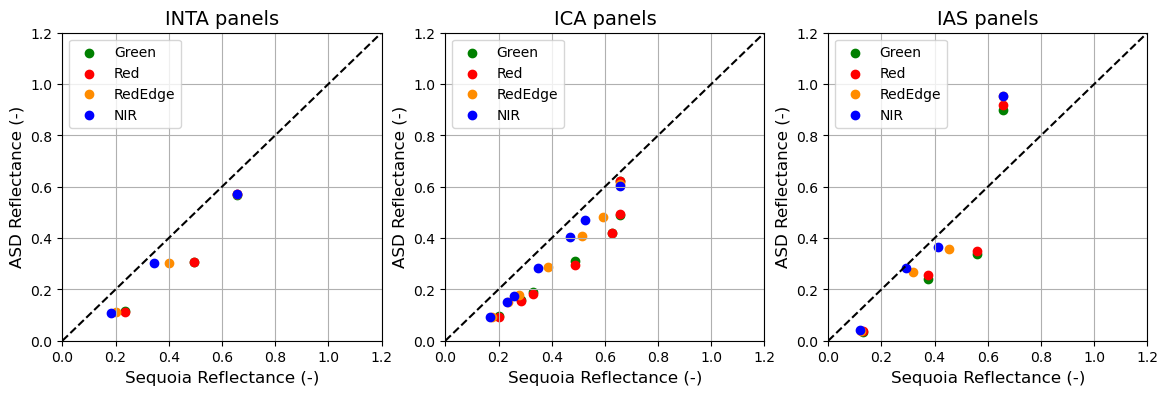

In [62]:
colors = ['g', 'r', 'darkorange', 'blue']

# create 1x3 plot with each panel group 
fig, axes = plt.subplots(1,3, figsize=(14,4))
i = 0
for group in panel_groups:
    # select all panels related to this group (INTA, ICA or IAS)
    groups_select = list(panels_unique[panels_unique.str.contains(group)])
    groups_select.sort()
    
    # get asd data for particular group of pabels and round 1
    asd_data = asd_convolved_df[asd_convolved_df['panels'].str.contains(group) & asd_convolved_df['panels'].str.contains('R1')]
    # make sure panels sorted by lowest to highest
    asd_data = asd_data.sort_values(by = ['panels'])
    uav_data = uav_values_df[uav_values_df['panel_id'].str.contains(group)] 
    # make sure panels sorted by lowest to highest
    uav_data = uav_data.sort_values(by = ['panel_id'])
    # intialize axis
    ax = axes[i]
    b = 0
    # plot for each band
    for band in asd_data.columns[1:]:
        asd_values = asd_data[band].values 
        uav_values = uav_data[f'B{b+1}_val'].values
        ax.scatter(uav_values, asd_values, color=colors[b],label = band, marker='o')
        b = b + 1
        
    ax.grid(True)
    ax.plot([0, 1.2], [0, 1.2], color='black', linestyle='--')
    ax.legend()
    # intialize axis
    ax = axes[i]
    ax.set_title(f'{group} panels', fontsize=14)
    ax.set_xlabel('Sequoia Reflectance (-)', fontsize=12)
    ax.set_xlim(0, 1.2)
    ax.set_ylabel('ASD Reflectance (-)', fontsize=12)
    ax.set_ylim(0, 1.2)
    ax.grid(True)
    i = i +1 
plt.show()
  


In [66]:
# use dictonary to store of empirical model parameters
lm_dict = {}

for group in panel_groups:
    # select all panels related to this group (INTA, ICA or IAS)
    groups_select = list(panels_unique[panels_unique.str.contains(group)])
    # get asd data for particular group of pabels and round 1
    asd_data = asd_convolved_df[asd_convolved_df['panels'].str.contains(group) & asd_convolved_df['panels'].str.contains('R1')]
    # make sure panels sorted by lowest to highest
    asd_data = asd_data.sort_values(by = ['panels'])
    uav_data = uav_values_df[uav_values_df['panel_id'].str.contains(group)] 
    # make sure panels sorted by lowest to highest
    uav_data = uav_data.sort_values(by = ['panel_id']) 
    
    # initialize empty dictionary for each panel group to store results
    lm_dict[group] = {}
    # go through each band and develop linear model
    b = 0 
    for band in asd_data.columns[1:]:
        asd_values = asd_data[band].values 
        uav_values = uav_data[f'B{b+1}_val'].values
        lm = linregress(uav_values, asd_values)
        gain = lm.slope 
        offset = lm.intercept 
        r2 = lm.rvalue ** 2
        # store result as list of [gain, offset, r2]
        lm_dict[group][band] = [gain, offset, r2]
        b = b + 1

el_output = {}
# convert dict to INTA panels
inta_df = pd.DataFrame(lm_dict['INTA'])
inta_df.index = ['gain', 'offset', 'R2']
# convert dict to ICA panels
ica_df = pd.DataFrame(lm_dict['ICA'])
ica_df.index = ['gain', 'offset', 'R2']
# convert dict to IAS panels
ias_df = pd.DataFrame(lm_dict['IAS'])
ias_df.index = ['gain', 'offset', 'R2']

# Save the empirical line models to a json
el_output["INTA"] = inta_df.to_dict()
el_output["ICA"] = ica_df.to_dict()
el_output["IAS"] = ias_df.to_dict()
el_outputfile = uav_dir / f'Mosaic_REF_{w_image.value}_EL_{w_extraction.value}.json'
with open(el_outputfile, "w") as outfile: 
    json.dump(el_output, outfile, indent=4)

print(f"Saved Empirical-Line coefficients to {el_outputfile}")

display(Markdown(f':::{{table}} INTA pannels\n{inta_df.to_markdown(floatfmt=".4f")}\n:::'))
display(Markdown(f':::{{table}} ICA pannels\n{ica_df.to_markdown(floatfmt=".4f")}\n:::'))
display(Markdown(f':::{{table}} IAS pannels\n{ias_df.to_markdown(floatfmt=".4f")}\n:::'))


Saved Empirical-Line coefficients to dataset/uav_imagery/multi/Sequoia_ICA/mosaic/Mosaic_REF_Sequoia_ICA_0942_EL_centroid.json


:::{table} INTA pannels
|        |   Green |     Red |   RedEdge |     NIR |
|:-------|--------:|--------:|----------:|--------:|
| gain   |  1.0523 |  1.0671 |    1.0182 |  0.9718 |
| offset | -0.1577 | -0.1632 |   -0.0974 | -0.0567 |
| R2     |  0.9511 |  0.9504 |    0.9995 |  0.9934 |
:::

:::{table} ICA pannels
|        |   Green |     Red |   RedEdge |     NIR |
|:-------|--------:|--------:|----------:|--------:|
| gain   |  0.9672 |  0.9759 |    1.0204 |  1.0607 |
| offset | -0.1210 | -0.1287 |   -0.0974 | -0.0917 |
| R2     |  0.9159 |  0.9138 |    0.9875 |  0.9992 |
:::

:::{table} IAS pannels
|        |   Green |     Red |   RedEdge |     NIR |
|:-------|--------:|--------:|----------:|--------:|
| gain   |  1.3886 |  1.4167 |    1.6555 |  1.6837 |
| offset | -0.2201 | -0.2200 |   -0.2362 | -0.2128 |
| R2     |  0.7495 |  0.7551 |    0.9081 |  0.9546 |
:::

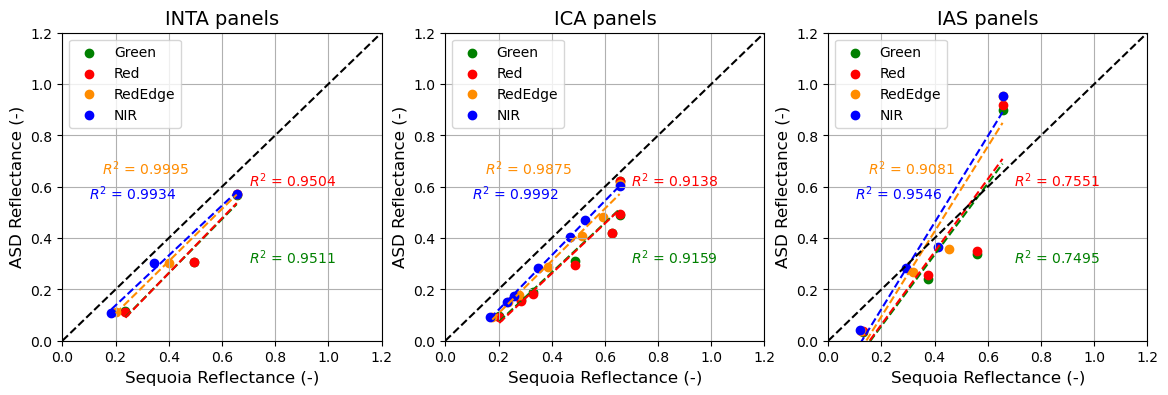

In [67]:
colors = ['g', 'r', 'darkorange', 'blue']

# create 1x3 plot with each panel group 
fig, axes = plt.subplots(1,3, figsize=(14,4))
i = 0
for group in panel_groups:
    # get linear model parameters associated to each group
    lm_panels = lm_dict[group]
    
    # select all panels related to this group (INTA, ICA or IAS)
    groups_select = list(panels_unique[panels_unique.str.contains(group)])
    # get asd data for particular group of panels and round 1
    asd_data = asd_convolved_df[asd_convolved_df['panels'].str.contains(group) & asd_convolved_df['panels'].str.contains('R1')]
    # make sure panels sorted by lowest to highest
    asd_data = asd_data.sort_values(by = ['panels'])
    uav_data = uav_values_df[uav_values_df['panel_id'].str.contains(group)] 
    # make sure panels sorted by lowest to highest
    uav_data = uav_data.sort_values(by = ['panel_id']) 
    # intialize axis
    ax = axes[i]
    b = 0
    for band in asd_data.columns[1:]:
        asd_values = asd_data[band].values 
        uav_values = uav_data[f'B{b+1}_val'].values
        ax.scatter(uav_values, asd_values, color=colors[b],label = band, marker='o')
        # get lm params
        gain = lm_panels[band][0]
        offset = lm_panels[band][1]
        r2 = lm_panels[band][2]
        # plot linear regression
        x_lm = (np.min(uav_values), np.max(uav_values))
        y_lm = (gain*np.min(uav_values) + offset, gain*np.max(uav_values)+offset)
        ax.plot(x_lm, y_lm, color=colors[b], linestyle = '--')
        b = b + 1
        
    # get r2 for each bands
    r2_green = lm_panels['Green'][2]
    r2_red = lm_panels['Red'][2]
    r2_rededge = lm_panels['RedEdge'][2]
    r2_nir = lm_panels['NIR'][2]
    
    # annotate r2 over figure
    ax.text(0.7, 0.3, f'$R^2$ = {np.round(r2_green,4)}', color=colors[0])
    ax.text(0.7, 0.6, f'$R^2$ = {np.round(r2_red,4)}', color=colors[1])
    ax.text(0.15, 0.65, f'$R^2$ = {np.round(r2_rededge,4)}', color=colors[2])
    ax.text(0.1, 0.55, f'$R^2$ = {np.round(r2_nir,4)}', color=colors[3])

    ax.grid(True)
    ax.plot([0, 1.2], [0, 1.2], color='black', linestyle='--')
    ax.legend()
    # intialize axis
    ax = axes[i]
    ax.set_title(f'{group} panels', fontsize=14)
    ax.set_xlabel('Sequoia Reflectance (-)', fontsize=12)
    ax.set_xlim(0, 1.2)
    ax.set_ylabel('ASD Reflectance (-)', fontsize=12)
    ax.set_ylim(0, 1.2)
    ax.grid(True)
    i = i +1 
plt.show()

### Visualize linear models

# Calibrate image with developed empirical model

Apply developed empirical line on each band of UAV image

In [68]:
# open uav image as gdal object
fid = gdal.Open(str(mosaic_file))

# get geotransform data
geotransform = fid.GetGeoTransform()
proj = fid.GetProjection()
minx, maxy = geotransform[0], geotransform[3]
maxx = minx + geotransform[1] * fid.RasterXSize
miny = maxy + geotransform[5] * fid.RasterYSize

# get metadata of image
num_bands = fid.RasterCount 
template_ar = fid.GetRasterBand(1).ReadAsArray()
rows, cols = template_ar.shape

# Read specific bands of uncalibrated image (4=NIR, 3=Red-Edge,2=Red and 1=Green)
nir_band = fid.GetRasterBand(4).ReadAsArray()  # Near-Infrared
rededge_band = fid.GetRasterBand(3).ReadAsArray()  # Red-edge
red_band = fid.GetRasterBand(2).ReadAsArray()  # Red
green_band = fid.GetRasterBand(1).ReadAsArray()  # Green

# initiazline empty 3D array with same number of bands 
ar_inta_cal = np.full((rows, cols, num_bands), np.nan)
ar_ica_cal = np.full((rows, cols, num_bands), np.nan)
ar_ias_cal = np.full((rows, cols, num_bands), np.nan)


for band in range(num_bands):
    ar = fid.GetRasterBand(band+1).ReadAsArray()
    # get band name in string
    band_name = band_names[band]
    # inta LM/EL parameters
    gain, offset = lm_dict['INTA'][band_name][:2]
    # calibrate based on INTA reference panels
    ar_inta_cal[:,:,band] = (gain*ar) + offset
    # ica LM/EL parameters
    gain, offset = lm_dict['ICA'][band_name][:2]
    # calibrate based on ICA reference panels
    ar_ica_cal[:,:,band] = (gain*ar) + offset
    # ias LM/EL parameters
    gain, offset = lm_dict['IAS'][band_name][:2]
    # calibrate based on IAS reference panels
    ar_ias_cal[:,:,band] = (gain*ar) + offset

# save calibrated images as geotiffs
for group in panel_groups:
    outfilename = mosaic_file.name[:-4] + f'_EL_{group}panels_{w_extraction.value}.tif'
    outfile = uav_dir / outfilename
    driver = gdal.GetDriverByName('GTiff')
    nbands = ar_inta_cal.shape[2]
    
    ds = driver.Create(str(outfile), cols, rows, nbands, gdal.GDT_Float32)
    ds.SetGeoTransform(geotransform)
    ds.SetProjection(proj)
    input_nodata = np.nan
    if group == 'INTA':
        ar_img = ar_inta_cal
    elif group == 'ICA':
        ar_img = ar_ica_cal
    else:
        ar_img = ar_ias_cal


    for i in range(nbands):
        band = ds.GetRasterBand(i+1)
        band.SetNoDataValue(input_nodata)
        array = ar_img[:,:,i]
        array[np.isnan(array)] = input_nodata
        band.WriteArray(array)
        band.FlushCache()
    
    ds.FlushCache()
    ds = None
    print(f'Calibrated image using {group} panels saved as {str(outfile)}')


Calibrated image using INTA panels saved as dataset/uav_imagery/multi/Sequoia_ICA/mosaic/Mosaic_REF_Sequoia_ICA_0942_EL_INTApanels_centroid.tif
Calibrated image using ICA panels saved as dataset/uav_imagery/multi/Sequoia_ICA/mosaic/Mosaic_REF_Sequoia_ICA_0942_EL_ICApanels_centroid.tif
Calibrated image using IAS panels saved as dataset/uav_imagery/multi/Sequoia_ICA/mosaic/Mosaic_REF_Sequoia_ICA_0942_EL_IASpanels_centroid.tif


## Visual comparison of calibrated vs original images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16322955558815572..0.5801887603462772].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.128677239271625..0.6034340222931649].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.22010955346404038..0.8906280468037302].


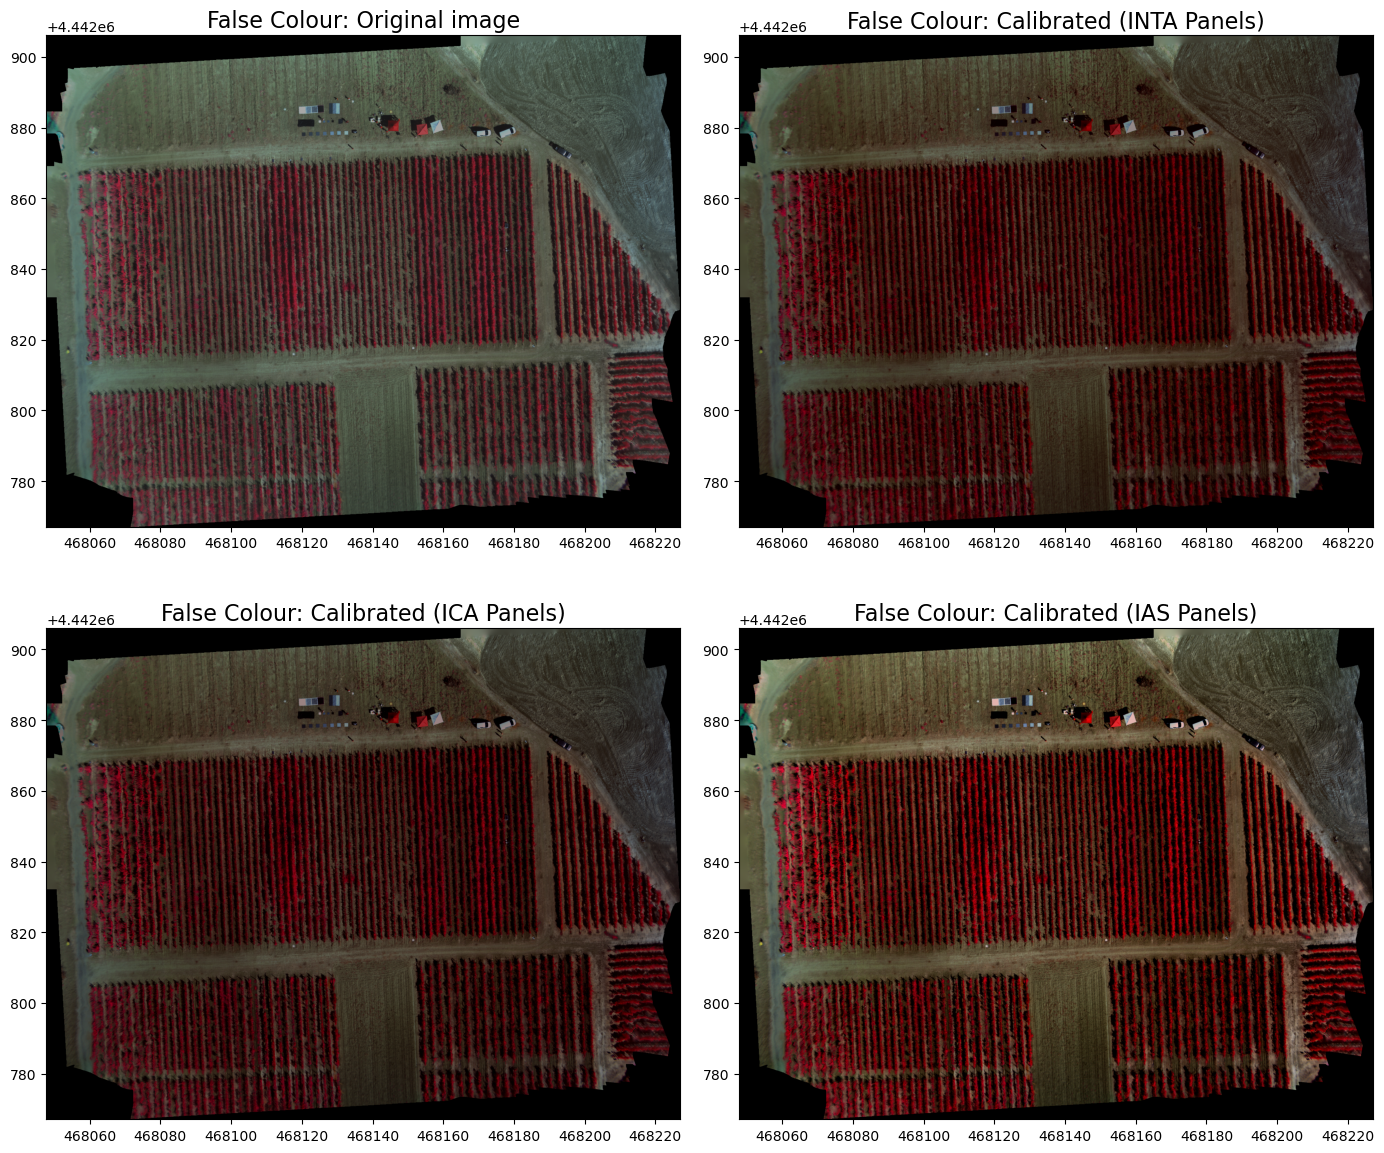

In [69]:
# Stack the calibrated bands to obtain false colour
false_color_inta = np.dstack((ar_inta_cal[:,:,3], ar_inta_cal[:,:,1],  ar_inta_cal[:,:,0]))
false_color_ica = np.dstack((ar_ica_cal[:,:,3], ar_ica_cal[:,:,1],  ar_ica_cal[:,:,0]))
false_color_ias = np.dstack((ar_ias_cal[:,:,3], ar_ias_cal[:,:,1],  ar_ias_cal[:,:,0]))

# Stack the uncalcalibrated bands to obtain false colour
false_color_uncal = np.dstack((nir_band, red_band,  green_band))

# make side by side false colour figure
fig, axes = plt.subplots(2,2, figsize=(14,12))
# calibrated with INTA panels
ax1 = axes[0,0]
ax1.imshow(false_color_uncal, extent=[minx, maxx, miny, maxy])
ax1.set_title('False Colour: Original image', fontsize=16)

ax2 = axes[0,1]
ax2.imshow(false_color_inta, extent=[minx, maxx, miny, maxy])
ax2.set_title('False Colour: Calibrated (INTA Panels)', fontsize=16)

# calibrated with ICA panels
ax3 = axes[1,0]
ax3.imshow(false_color_ica, extent=[minx, maxx, miny, maxy])
ax3.set_title('False Colour: Calibrated (ICA Panels)', fontsize=16)

# calibrated with IAS panels
ax4 = axes[1,1]
ax4.imshow(false_color_ias, extent=[minx, maxx, miny, maxy])
ax4.set_title('False Colour: Calibrated (IAS Panels)',fontsize=16)

plt.tight_layout()
#ax2.set_xlim(468115,468140)
#ax2.set_ylim(4442870,4442890)
plt.show()


## Evaluate calibrated images against ASD data 
### extract calibrated UAV data over reference panels

In [70]:
uav_cal_values_df = pd.DataFrame(columns=["panel_id"])

for group in panel_groups:
    # get calibrated images
    img_file = uav_dir / f'Mosaic_REF_{w_image.value}_EL_{group}panels_{w_extraction.value}.tif'
    for b in range(num_bands):
        # Define the name of the band
        col_id = f'B{b+1}_{group}'
        # Extract zonal statistics using Raster Stats
        extract_json = zonal_stats(panels_gdf, img_file, band_num=b, stats=stat, geojson_out=True)
        # Loop along the panels extracted and create a table
        panel_values = {"panel_id": [], col_id:[]}
        for p in extract_json:
            panel_name = p["properties"]["code"]
            panel_values["panel_id"].append(panel_name)
            panel_values[col_id].append(p["properties"][stat])
            
        panel_values = pd.DataFrame(panel_values)
        # Join tables
        uav_cal_values_df = pd.merge(uav_cal_values_df, panel_values, on="panel_id", how="outer")

# Save the extractions to a CSV table
csv_output = uav_dir / f'Mosaic_REF_{w_image.value}_EL_{w_extraction.value}.csv'
uav_cal_values_df.to_csv(csv_output, index=False, sep=";")
print(f"Empirical-line Extractions saved to {csv_output}")

# Display the extractions
display(Markdown(f':::{{table}} Calibration pannel extractions of empirical-line image using {w_extraction.value}s\n{uav_cal_values_df.to_markdown(index=False, floatfmt=".4f")}\n:::'))

Empirical-line Extractions saved to dataset/uav_imagery/multi/Sequoia_ICA/mosaic/Mosaic_REF_Sequoia_ICA_0942_EL_centroid.csv


:::{table} Calibration pannel extractions of empirical-line image using centroids
| panel_id   |   B1_INTA |   B2_INTA |   B3_INTA |   B4_INTA |   B1_ICA |   B2_ICA |   B3_ICA |   B4_ICA |   B1_IAS |   B2_IAS |   B3_IAS |   B4_IAS |
|:-----------|----------:|----------:|----------:|----------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|
| IAS1       |    0.5319 |    0.5319 |    0.5361 |    0.5698 |   0.5128 |   0.5128 |   0.5109 |   0.5713 |   0.6899 |   0.6899 |   0.7084 |   0.8487 |
| IAS2       |    0.4323 |    0.4323 |    0.3206 |    0.3226 |   0.4213 |   0.4213 |   0.3138 |   0.3235 |   0.5585 |   0.5585 |   0.4223 |   0.4468 |
| IAS3       |    0.2382 |    0.2382 |    0.1770 |    0.2012 |   0.2429 |   0.2429 |   0.1824 |   0.2018 |   0.3023 |   0.3023 |   0.2317 |   0.2493 |
| IAS4       |   -0.0189 |   -0.0189 |   -0.0338 |    0.0239 |   0.0066 |   0.0066 |  -0.0103 |   0.0242 |  -0.0369 |  -0.0369 |  -0.0482 |  -0.0389 |
| ICA1       |    0.5319 |    0.5319 |    0.5361 |    0.5698 |   0.5128 |   0.5128 |   0.5109 |   0.5713 |   0.6899 |   0.6899 |   0.7084 |   0.8487 |
| ICA2       |    0.5319 |    0.5319 |    0.4675 |    0.4384 |   0.5128 |   0.5128 |   0.4481 |   0.4395 |   0.6899 |   0.6899 |   0.6173 |   0.6350 |
| ICA3       |    0.5030 |    0.5030 |    0.3868 |    0.3782 |   0.4862 |   0.4862 |   0.3743 |   0.3793 |   0.6517 |   0.6517 |   0.5102 |   0.5373 |
| ICA4       |    0.3541 |    0.3541 |    0.2474 |    0.2587 |   0.3493 |   0.3493 |   0.2469 |   0.2595 |   0.4552 |   0.4552 |   0.3252 |   0.3428 |
| ICA5       |    0.1892 |    0.1892 |    0.1312 |    0.1651 |   0.1978 |   0.1978 |   0.1406 |   0.1656 |   0.2377 |   0.2377 |   0.1709 |   0.1906 |
| ICA6       |    0.1405 |    0.1405 |    0.0877 |    0.1371 |   0.1530 |   0.1530 |   0.1008 |   0.1377 |   0.1734 |   0.1734 |   0.1131 |   0.1452 |
| ICA7       |    0.0557 |    0.0557 |    0.0248 |    0.0742 |   0.0751 |   0.0751 |   0.0433 |   0.0745 |   0.0615 |   0.0615 |   0.0296 |   0.0428 |
| INTA1      |    0.5319 |    0.5319 |    0.5361 |    0.5698 |   0.5128 |   0.5128 |   0.5109 |   0.5713 |   0.6899 |   0.6899 |   0.7084 |   0.8487 |
| INTA2      |    0.3625 |    0.3625 |    0.2626 |    0.2551 |   0.3571 |   0.3571 |   0.2607 |   0.2559 |   0.4663 |   0.4663 |   0.3453 |   0.3370 |
| INTA3      |    0.0919 |    0.0919 |    0.0506 |    0.0904 |   0.1084 |   0.1084 |   0.0669 |   0.0908 |   0.1092 |   0.1092 |   0.0639 |   0.0692 |
:::

### Plot calibrated UAV reflectance against ASD data

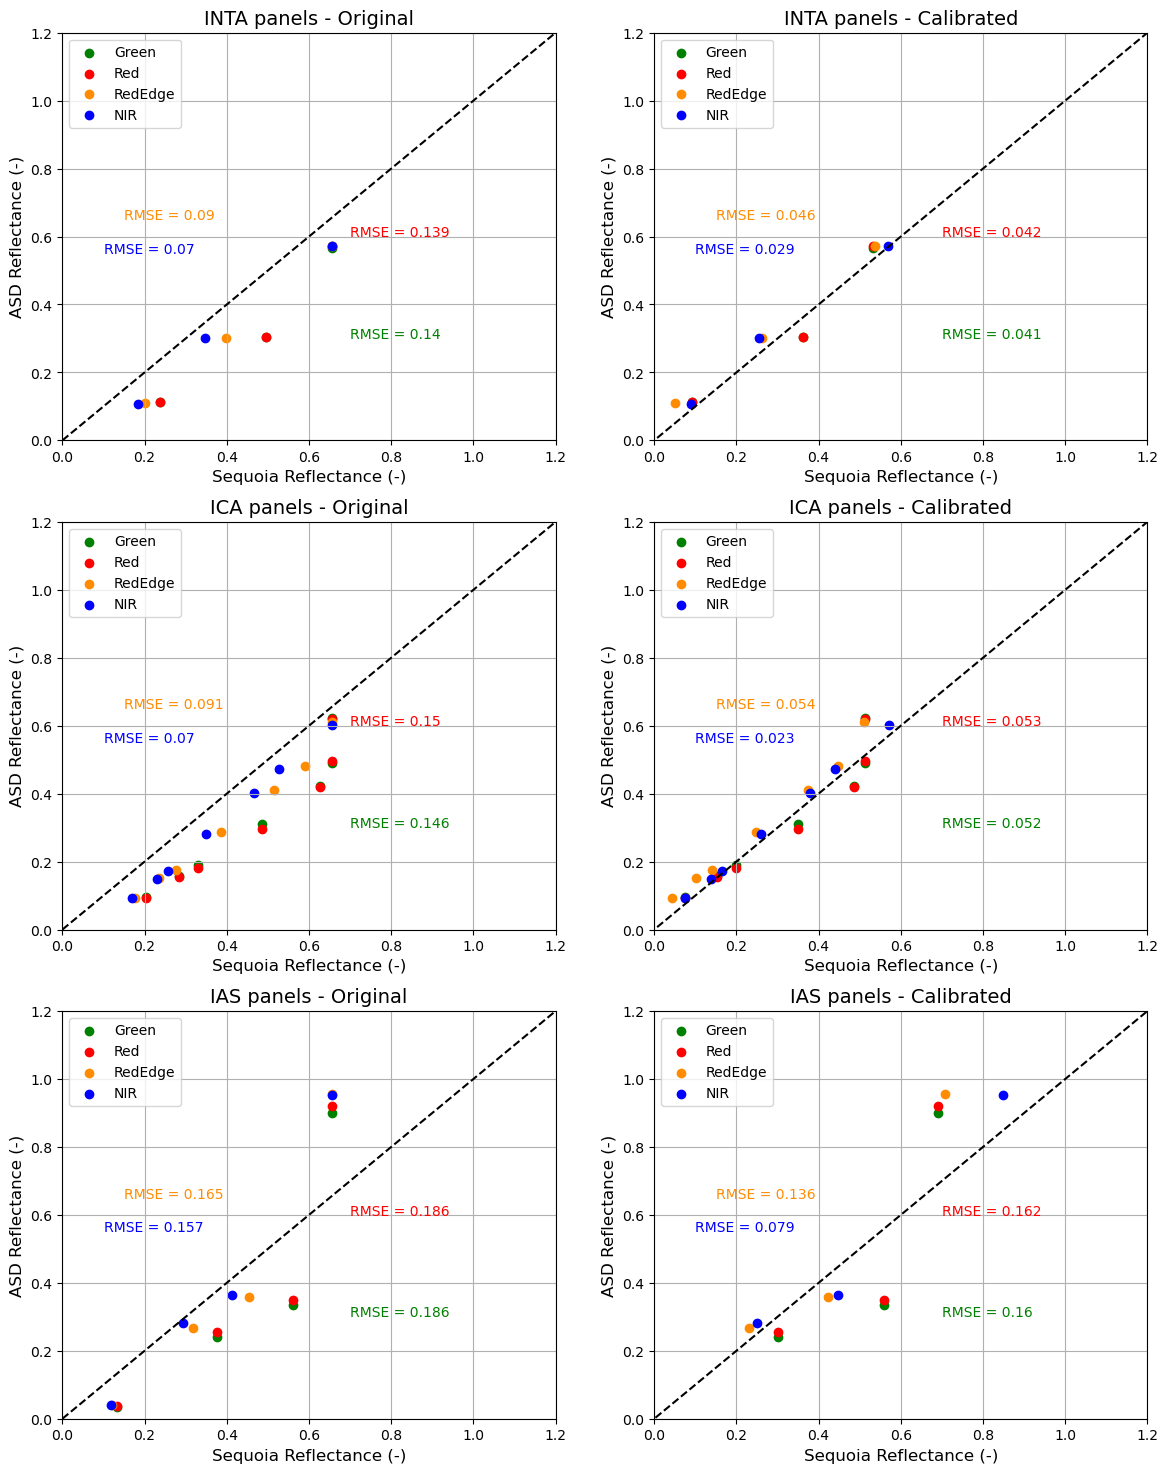

In [72]:
# function to calculate RMSE
def calc_rmse(obs, pred):
    rmse = np.sqrt(np.nanmean((pred - obs) ** 2))
    return rmse

colors = ['g', 'r', 'darkorange', 'blue']

# create 1x3 plot with each panel group 
fig, axes = plt.subplots(3,2, figsize=(14,18))
i = 0
for group in panel_groups:
    # select all panels related to this group (INTA, ICA or IAS)
    groups_select = list(panels_unique[panels_unique.str.contains(group)])
    # get asd data for particular group of pabels and round 1
    asd_data = asd_convolved_df[asd_convolved_df['panels'].str.contains(group) & asd_convolved_df['panels'].str.contains('R1')]
    asd_data = asd_data.sort_values(by = ['panels'])
    # original UAV data over panels
    uav_data = uav_values_df[uav_values_df['panel_id'].str.contains(group)] 
    uav_data = uav_data.sort_values(by = ['panel_id'])

    # calibrated UAV data over panels
    cal_data = uav_cal_values_df[uav_cal_values_df['panel_id'].str.contains(group)] 
    cal_data = cal_data.sort_values(by = ['panel_id'])

    # intialize axis
    ax = axes[i,0]
    b = 0
    rmse_og = []
    for band in asd_data.columns[1:]:
        asd_values = asd_data[band].values 
        uav_values = uav_data[f'B{b+1}_val'].values
        rmse = calc_rmse(asd_values, uav_values)
        rmse_og.append(rmse)
        ax.scatter(uav_values, asd_values, color=colors[b],label = band, marker='o')
        b = b + 1

    ax.text(0.7, 0.3, f'RMSE = {np.round(rmse_og[0],3)}', color=colors[0])
    ax.text(0.7, 0.6, f'RMSE = {np.round(rmse_og[1],3)}', color=colors[1])
    ax.text(0.15, 0.65, f'RMSE = {np.round(rmse_og[2],3)}', color=colors[2])
    ax.text(0.1, 0.55, f'RMSE = {np.round(rmse_og[3],3)}', color=colors[3])
    
    ax.grid(True)
    ax.plot([0, 1.2], [0, 1.2], color='black', linestyle='--')
    ax.legend()
    ax.set_title(f'{group} panels - Original', fontsize=14)
    ax.set_xlabel('Sequoia Reflectance (-)', fontsize=12)
    ax.set_xlim(0, 1.2)
    ax.set_ylabel('ASD Reflectance (-)', fontsize=12)
    ax.set_ylim(0, 1.2)
    ax.grid(True)

    ax2 = axes[i,1]
    b = 0
    rmse_cal = []
    for band in asd_data.columns[1:]:
        asd_values = asd_data[band].values 
        cal_values = cal_data[f'B{b+1}_{group}'].values
        rmse = calc_rmse(asd_values, cal_values)
        rmse_cal.append(rmse)
        ax2.scatter(cal_values, asd_values, color=colors[b],label = band, marker='o')
        b = b + 1

    ax2.text(0.7, 0.3, f'RMSE = {np.round(rmse_cal[0],3)}', color=colors[0])
    ax2.text(0.7, 0.6, f'RMSE = {np.round(rmse_cal[1],3)}', color=colors[1])
    ax2.text(0.15, 0.65, f'RMSE = {np.round(rmse_cal[2],3)}', color=colors[2])
    ax2.text(0.1, 0.55, f'RMSE = {np.round(rmse_cal[3],3)}', color=colors[3])
    
    ax2.grid(True)
    ax2.plot([-0.2, 1.2], [-0.2, 1.2], color='black', linestyle='--')
    ax2.legend()
    ax2.set_title(f'{group} panels - Calibrated', fontsize=14)
    ax2.set_xlabel('Sequoia Reflectance (-)', fontsize=12)
    ax2.set_xlim(0, 1.2)
    ax2.set_ylabel('ASD Reflectance (-)', fontsize=12)
    ax2.set_ylim(0, 1.2)
    ax2.grid(True)
    i = i +1 
plt.show()
  


# Next Steps?

- evaluate different multispectral sensors
- evaluate different sensor types (TIR, Hyperspectral)
- individual tile vs orthomosaic
- homogeneity analysis of panels
- best method to extract UAV data over panels? Radius (square, circle)? what size?
- timing of ASD measurements (round 1 vs round 2 vs round 3)
- number of panels to use?
- other??